<h2>THEME: CLIMATE RISK AND DISASTER MANAGEMENT<h2>

<h3>PROJECT: DISASTER TWEETS CLASSIFIER<h3>

In [19]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve


In [20]:

data = pd.read_csv("train.csv") 
print(data.head(10))

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   
5   8     NaN      NaN  #RockyFire Update => California Hwy. 20 closed...   
6  10     NaN      NaN  #flood #disaster Heavy rain causes flash flood...   
7  13     NaN      NaN  I'm on top of the hill and I can see a fire in...   
8  14     NaN      NaN  There's an emergency evacuation happening now ...   
9  15     NaN      NaN  I'm afraid that the tornado is coming to our a...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
5       1  
6       1  
7       1  
8       1  
9       1  


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [22]:
data.describe()
data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

## Data Preprocessing  
We clean tweets by converting text to lowercase, removing links, mentions, hashtags, special characters, numbers, and extra spaces.  
This creates a new column **`clean_text`** that contains cleaned versions of the tweet as shown in below code  

In [23]:
def clean_text(text):
    text = text.lower()  
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  
    text = re.sub(r'\@w+|\#','', text)  
    text = re.sub(r'[^A-Za-z\s]', '', text)  
    text = text.strip()  
    return text

data['clean_text'] = data['text'].apply(clean_text)
print(data[['text','clean_text']].head())

                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                          clean_text  
0  our deeds are the reason of this earthquake ma...  
1              forest fire near la ronge sask canada  
2  all residents asked to shelter in place are be...  
3  people receive wildfires evacuation orders in ...  
4  just got sent this photo from ruby alaska as s...  


## Exploratory Data Analysis (EDA)  

###  Class Distribution  
We check the balance between disaster (1) and non-disaster (0) tweets.  

###  Tweet Length Distribution  
We compare tweet lengths to see if disaster tweets are generally longer than non-disaster tweets.  

###  WordCloud Visualization  
We generate word clouds to identify the most frequent words in both categories.  


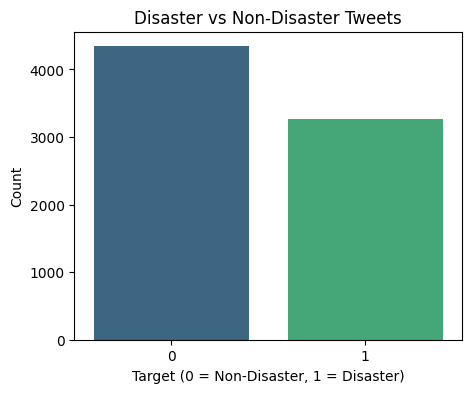

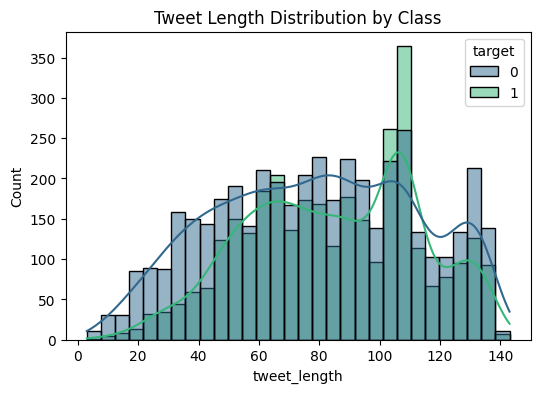

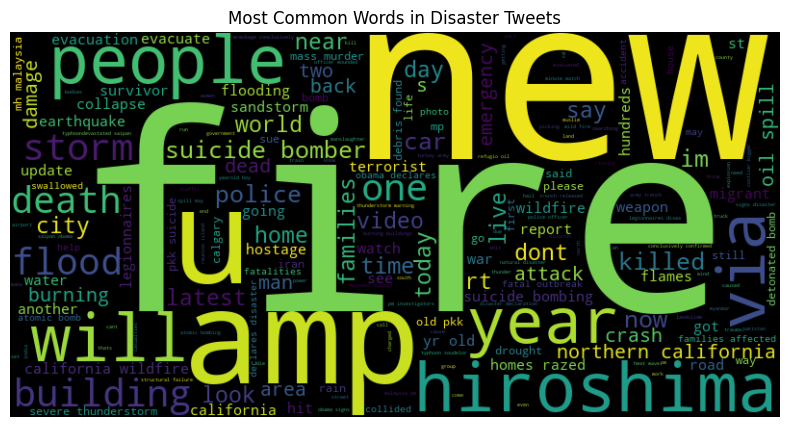

In [24]:
from wordcloud import WordCloud

plt.figure(figsize=(5,4))
sns.countplot(x='target', hue='target', data=data, palette='viridis', dodge=False)
plt.title("Disaster vs Non-Disaster Tweets")
plt.xlabel("Target (0 = Non-Disaster, 1 = Disaster)")
plt.ylabel("Count")
plt.legend([],[], frameon=False)   
plt.show()

data['tweet_length'] = data['clean_text'].apply(len)
plt.figure(figsize=(6,4))
sns.histplot(data=data, x='tweet_length', bins=30, hue='target', kde=True, palette='viridis')
plt.title("Tweet Length Distribution by Class")
plt.show()

disaster_words = " ".join(data[data['target']==1]['clean_text'])
wc = WordCloud(width=800, height=400, background_color="black").generate(disaster_words)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Disaster Tweets")
plt.show()

In [25]:
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf.fit_transform(data['clean_text'])
y = data['target']
print("Shape of TF-IDF matrix:", X.shape)

Shape of TF-IDF matrix: (7613, 5000)


## 6. Feature Selection  
We apply **TF-IDF Vectorization** to convert text into numeric features, keeping only the top 5000 words to reduce noise.  


In [26]:
from sklearn.feature_selection import chi2
chi2_scores, _ = chi2(X, y)
features = tfidf.get_feature_names_out()
top = pd.Series(chi2_scores, index=features).nlargest(20)
print("Top 20 features by chi2:\n", top)

Top 20 features by chi2:
 california      38.756462
hiroshima       36.079150
suicide         31.780509
mh              30.416217
killed          30.390153
northern        26.843705
wildfire        26.732940
bombing         25.999204
families        24.776781
legionnaires    23.809116
fires           22.890665
homes           22.419217
im              22.242453
bomber          21.258147
malaysia        21.063183
atomic          21.036899
pm              20.683159
debris          20.683017
confirmed       19.329601
train           18.256318
dtype: float64


## Train-Test Split  
We split the dataset into **training (80%)** and **testing (20%)** sets to evaluate the model’s performance on unseen data.  


In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Logistic Regression Model  
We train a **Logistic Regression classifier** on the TF-IDF features. This baseline model is simple, fast, and effective for text classification.  


In [28]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

## Model Evaluation  
We evaluate the model using **Accuracy, Precision, Recall, F1-score**, along with a **Confusion Matrix** and **ROC Curve** to measure performance.  


In [29]:
y_pred = lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8095863427445831
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       869
           1       0.79      0.76      0.77       654

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



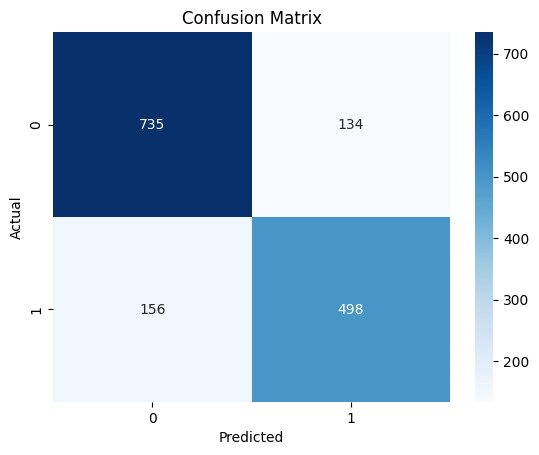

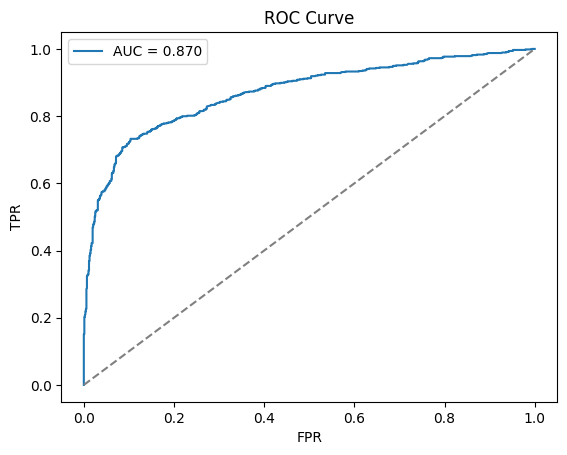

In [30]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
plt.show()

probs = lr.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, probs):.3f}")
plt.plot([0,1],[0,1], '--', color='gray')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.show()

In [31]:
params = {'C':[0.01,0.1,1,5,10]}
grid = GridSearchCV(LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear'),
                    param_grid=params, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)
print("Best Params:", grid.best_params_)

best_lr = grid.best_estimator_
y_pred_best = best_lr.predict(X_test)
print("Tuned Model Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

Best Params: {'C': 1}
Tuned Model Accuracy: 0.8095863427445831
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       869
           1       0.79      0.76      0.77       654

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



## Conclusion  
Logistic Regression with TF-IDF achieved ~81% accuracy.  
The model is effective at distinguishing disaster tweets from non-disaster ones.  
Future improvements could include using advanced models like BERT or adding engineered features.  
